##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# How to use the GFSA layer for new tasks

This notebook describes the high-level process for using the GFSA layer in a new task, specifically focusing on how to represent a new type of graph as an MDP so that you can use the GFSA layer.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-research/google-research/blob/master/gfsa/notebooks/guide_for_new_tasks.ipynb)

### Setup and imports

In [2]:
!git clone https://github.com/google-research/google-research.git --depth=1

Cloning into 'google-research'...
remote: Enumerating objects: 9929, done.
remote: Counting objects: 100% (9929/9929), done.
remote: Compressing objects: 100% (7957/7957), done.
remote: Total 9929 (delta 1409), reused 7837 (delta 1180), pack-reused 0
Receiving objects: 100% (9929/9929), 109.27 MiB | 20.40 MiB/s, done.
Resolving deltas: 100% (1409/1409), done.
Checking out files: 100% (10428/10428), done.


In [3]:
import os
os.chdir("google-research")

In [4]:
!pip install flax

     |████████████████████████████████| 153kB 4.2MB/s 


In [5]:
import gast
import numpy as np

from gfsa import automaton_builder
from gfsa import generic_ast_graphs
from gfsa import graph_types
from gfsa import py_ast_graphs
from gfsa import schema_util
from gfsa.datasets.mazes import maze_schema
from gfsa.datasets.mazes import maze_task
from gfsa.visualization.pprint import pprint
from gfsa.visualization.pytrees import summarize_tree

## Defining your graph domain

The first step in using the GFSA layer for a new task is to specify how to interpret the graphs in your domain as MDPs. Specifically, you must define a set of node types, and then for each node type, define the set of possible actions ("out edges") the agent can take at that node, and the set of observations ("in edges") the agent can receive when it arrives at the node. In the codebase, this is referred to as a "graph schema".

For the dataset of simple Python functions, the graph schema is derived from a simpler "AST specification":

In [6]:
# AST specification:
py_ast_graphs.PY_AST_SPECS

{'Add': ASTNodeSpec(fields={}, sequence_item_types={}, has_parent=True),
 'And': ASTNodeSpec(fields={}, sequence_item_types={}, has_parent=True),
 'Assign': ASTNodeSpec(fields={'targets': FieldType.ONE_CHILD, 'value': FieldType.ONE_CHILD}, sequence_item_types={}, has_parent=True),
 'BinOp': ASTNodeSpec(fields={'left': FieldType.ONE_CHILD, 'op': FieldType.ONE_CHILD, 'right': FieldType.ONE_CHILD}, sequence_item_types={}, has_parent=True),
 'BoolOp': ASTNodeSpec(fields={'op': FieldType.ONE_CHILD, 'values': FieldType.NONEMPTY_SEQUENCE}, sequence_item_types={'values': 'BoolOp_values'}, has_parent=True),
 'Break': ASTNodeSpec(fields={}, sequence_item_types={}, has_parent=True),
 'Call': ASTNodeSpec(fields={'func': FieldType.ONE_CHILD, 'args': FieldType.SEQUENCE, 'keywords': FieldType.NO_CHILDREN}, sequence_item_types={'args': 'Call_args'}, has_parent=True),
 'Compare': ASTNodeSpec(fields={'left': FieldType.ONE_CHILD, 'ops': FieldType.ONE_CHILD, 'comparators': FieldType.ONE_CHILD}, sequence_i

In [7]:
# Derived schema (using `generic_ast_graphs.build_ast_graph_schema`)
py_ast_graphs.SCHEMA

{'Add': NodeSchema(in_edges=['parent_in'], out_edges=['parent_out']),
 'And': NodeSchema(in_edges=['parent_in'], out_edges=['parent_out']),
 'Assign': NodeSchema(in_edges=['parent_in', 'targets_in', 'value_in'], out_edges=['parent_out', 'targets_out', 'value_out']),
 'BinOp': NodeSchema(in_edges=['parent_in', 'left_in', 'op_in', 'right_in'], out_edges=['parent_out', 'left_out', 'op_out', 'right_out']),
 'BoolOp': NodeSchema(in_edges=['parent_in', 'op_in', 'values_in'], out_edges=['parent_out', 'op_out', 'values_out_all', 'values_out_first', 'values_out_last']),
 'BoolOp_values-seq-helper': NodeSchema(in_edges=['parent_in', 'item_in', 'next_in', 'next_missing', 'prev_in', 'prev_missing'], out_edges=['parent_out', 'item_out', 'next_out', 'prev_out']),
 'Break': NodeSchema(in_edges=['parent_in'], out_edges=['parent_out']),
 'Call': NodeSchema(in_edges=['parent_in', 'func_in', 'args_in', 'args_missing'], out_edges=['parent_out', 'func_out', 'args_out_all', 'args_out_first', 'args_out_last'

It's possible to infer the AST specification from a dataset of ASTs using `ast_spec_inference.py`. In the paper, we use two different AST specifications, one for the synthetic Python examples (shown above), and one for the Python examples written by humans (since these use many additional types of AST nodes).

For the maze dataset, the node types are determined by the shape of the grid cell, and the graph schema determines which actions are valid:

In [8]:
maze_task.SCHEMA

{'cell_LRUD': NodeSchema(in_edges=['L_in', 'R_in', 'U_in', 'D_in'], out_edges=['L_out', 'R_out', 'U_out', 'D_out']),
 'cell_LRUx': NodeSchema(in_edges=['L_in', 'R_in', 'U_in'], out_edges=['L_out', 'R_out', 'U_out']),
 'cell_LRxD': NodeSchema(in_edges=['L_in', 'R_in', 'D_in'], out_edges=['L_out', 'R_out', 'D_out']),
 'cell_LRxx': NodeSchema(in_edges=['L_in', 'R_in'], out_edges=['L_out', 'R_out']),
 'cell_LxUD': NodeSchema(in_edges=['L_in', 'U_in', 'D_in'], out_edges=['L_out', 'U_out', 'D_out']),
 'cell_LxUx': NodeSchema(in_edges=['L_in', 'U_in'], out_edges=['L_out', 'U_out']),
 'cell_LxxD': NodeSchema(in_edges=['L_in', 'D_in'], out_edges=['L_out', 'D_out']),
 'cell_xRUD': NodeSchema(in_edges=['R_in', 'U_in', 'D_in'], out_edges=['R_out', 'U_out', 'D_out']),
 'cell_xRUx': NodeSchema(in_edges=['R_in', 'U_in'], out_edges=['R_out', 'U_out']),
 'cell_xRxD': NodeSchema(in_edges=['R_in', 'D_in'], out_edges=['R_out', 'D_out']),
 'cell_xxUD': NodeSchema(in_edges=['U_in', 'D_in'], out_edges=['U_ou

As a toy example of how you might encode a new graph domain, suppose we have a network of houses connected by directed roads. Each house is adjacent to exactly one road, and each road has at least one entry and exit point but may have more.

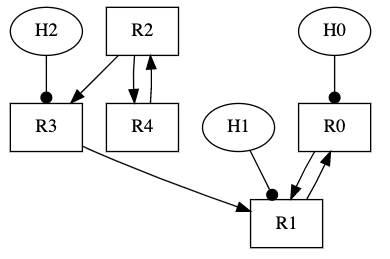

We can encode this structure using the following schema:

In [9]:
road_network_schema = {
    # Houses are only connected to roads, so the only movement action
    # available is to go to the road; likewise the only observation we receive
    # after moving is the observation that we arrived from a road.
    "house": graph_types.NodeSchema(
        in_edges=["from_road"],
        out_edges=["to_road"]),
    # Roads are more complex. We can always move to a random previous or next
    # road in the road network. We can also try to move to a house, but if there
    # is no house, we will have to stay on the road. We denote this with a
    # special observation (in `in_edges`).
    "road": graph_types.NodeSchema(
        in_edges=["from_next", "from_prev", "from_house", "no_house_here"],
        out_edges=["to_next", "to_prev", "to_house"]),
}
road_network_schema

{'house': NodeSchema(in_edges=['from_road'], out_edges=['to_road']),
 'road': NodeSchema(in_edges=['from_next', 'from_prev', 'from_house', 'no_house_here'], out_edges=['to_next', 'to_prev', 'to_house'])}

## Building MDP graphs

Before running the GFSA layer on a specific input graph, you need to specify the result of taking each of the actions defined in the schema.

For AST graphs, these transitions can be automatically computed based on the AST and its specification:

In [10]:
the_ast = gast.parse("""
def test_function(foo):
  if foo:
    return
  pass
""")
generic_ast = py_ast_graphs.py_ast_to_generic(the_ast)
mdp_graph, id_conversion_map = generic_ast_graphs.ast_to_graph(generic_ast, ast_spec=py_ast_graphs.PY_AST_SPECS)

schema_util.assert_conforms_to_schema(mdp_graph, py_ast_graphs.SCHEMA)

mdp_graph

{'root__Module': GraphNode(node_type='Module', out_edges={'body_out_all': [InputTaggedNode(node_id='root_body_0__Module_body-seq-helper', in_edge='parent_in')], 'body_out_first': [InputTaggedNode(node_id='root_body_0__Module_body-seq-helper', in_edge='parent_in')], 'body_out_last': [InputTaggedNode(node_id='root_body_0__Module_body-seq-helper', in_edge='parent_in')]}),
 'root_body_0__Module_body-seq-helper': GraphNode(node_type='Module_body-seq-helper', out_edges={'parent_out': [InputTaggedNode(node_id='root__Module', in_edge='body_in')], 'item_out': [InputTaggedNode(node_id='root_body_0_item__FunctionDef', in_edge='parent_in')], 'prev_out': [InputTaggedNode(node_id='root_body_0__Module_body-seq-helper', in_edge='prev_missing')], 'next_out': [InputTaggedNode(node_id='root_body_0__Module_body-seq-helper', in_edge='next_missing')]}),
 'root_body_0_item__FunctionDef': GraphNode(node_type='FunctionDef', out_edges={'parent_out': [InputTaggedNode(node_id='root_body_0__Module_body-seq-helper'

In the maze dataset, we precompute the destination of taking each possible action at each possible node:

In [11]:
the_maze_raw = [
  "███████  ████",
  "████  █  █  █",
  "████  ███████",
]
the_maze = np.array([[c != " " for c in r] for r in the_maze_raw])
mdp_graph, coordinates = maze_schema.encode_maze(the_maze)

schema_util.assert_conforms_to_schema(mdp_graph, maze_task.SCHEMA)

mdp_graph

{'cell_0_0': GraphNode(node_type='cell_xRxD', out_edges={'R_out': [InputTaggedNode(node_id='cell_0_1', in_edge='L_in')], 'D_out': [InputTaggedNode(node_id='cell_1_0', in_edge='U_in')]}),
 'cell_0_1': GraphNode(node_type='cell_LRxD', out_edges={'L_out': [InputTaggedNode(node_id='cell_0_0', in_edge='R_in')], 'R_out': [InputTaggedNode(node_id='cell_0_2', in_edge='L_in')], 'D_out': [InputTaggedNode(node_id='cell_1_1', in_edge='U_in')]}),
 'cell_0_10': GraphNode(node_type='cell_LRxx', out_edges={'L_out': [InputTaggedNode(node_id='cell_0_9', in_edge='R_in')], 'R_out': [InputTaggedNode(node_id='cell_0_11', in_edge='L_in')]}),
 'cell_0_11': GraphNode(node_type='cell_LRxx', out_edges={'L_out': [InputTaggedNode(node_id='cell_0_10', in_edge='R_in')], 'R_out': [InputTaggedNode(node_id='cell_0_12', in_edge='L_in')]}),
 'cell_0_12': GraphNode(node_type='cell_LxxD', out_edges={'L_out': [InputTaggedNode(node_id='cell_0_11', in_edge='R_in')], 'D_out': [InputTaggedNode(node_id='cell_1_12', in_edge='U_in

For the toy houses-and-roads example above, we might have a graph that looks something like this:

In [12]:
GraphNode = graph_types.GraphNode
InputTaggedNode = graph_types.InputTaggedNode
mdp_graph = {
    'R0': GraphNode(node_type='road',
                    out_edges={
                        'to_next': [InputTaggedNode(node_id='R1', in_edge='from_prev')],
                        'to_prev': [InputTaggedNode(node_id='R1', in_edge='from_next')],
                        'to_house': [InputTaggedNode(node_id='H0', in_edge='from_road')]
                    }),
    'R1': GraphNode(node_type='road',
                    out_edges={
                        'to_next': [InputTaggedNode(node_id='R0', in_edge='from_prev')],
                        'to_prev': [InputTaggedNode(node_id='R0', in_edge='from_next'),
                                    InputTaggedNode(node_id='R3', in_edge='from_next')],
                        'to_house': [InputTaggedNode(node_id='H1', in_edge='from_road')]
                    }),
    'R2': GraphNode(node_type='road',
                    out_edges={
                        'to_next': [InputTaggedNode(node_id='R3', in_edge='from_prev'),
                                    InputTaggedNode(node_id='R4', in_edge='from_prev')],
                        'to_prev': [InputTaggedNode(node_id='R4', in_edge='from_next')],
                        'to_house': [InputTaggedNode(node_id='R2', in_edge='no_house_here')]
                    }),
    'R3': GraphNode(node_type='road',
                    out_edges={
                        'to_next': [InputTaggedNode(node_id='R1', in_edge='from_prev')],
                        'to_prev': [InputTaggedNode(node_id='R2', in_edge='from_next')],
                        'to_house': [InputTaggedNode(node_id='H2', in_edge='from_road')]
                    }),
    'R4': GraphNode(node_type='road',
                    out_edges={
                        'to_next': [InputTaggedNode(node_id='R2', in_edge='from_prev')],
                        'to_prev': [InputTaggedNode(node_id='R2', in_edge='from_next')],
                        'to_house': [InputTaggedNode(node_id='R4', in_edge='no_house_here')]
                    }),
    'H0': GraphNode(node_type='house',
                    out_edges={
                        'to_road': [InputTaggedNode(node_id='R0', in_edge='from_house')]
                    }),
    'H1': GraphNode(node_type='house',
                    out_edges={
                        'to_road': [InputTaggedNode(node_id='R1', in_edge='from_house')]
                    }),
    'H2': GraphNode(node_type='house',
                    out_edges={
                        'to_road': [InputTaggedNode(node_id='R3', in_edge='from_house')]
                    }),
}

schema_util.assert_conforms_to_schema(mdp_graph, road_network_schema)

Note that every action must have at least one destination and associated observation! This is the case even for roads with no house, for which the "to_house" action results in staying in place and getting a special sentinel observation.

## Encoding MDP graphs into GFSA-compatible NDArrays

Once you have an MDP graph that conforms to a schema, you can use an automaton builder object to encode that graph into a set of NDArrays:

In [13]:
road_builder = automaton_builder.AutomatonBuilder(road_network_schema)
pprint(summarize_tree(road_builder.encode_graph(mdp_graph, as_jax=False)))

(EncodedGraph(
     initial_to_in_tagged=SparseCoordOperator(
                              input_indices='int32(20, 1) [1, 16] nz:1.0',
                              output_indices='int32(20, 2) [0, 17] nz:0.9',
                              values='float32(20,) 0.9 ±0.2 [0.5, 1.0]'),
     initial_to_special='int32(8,) [1, 6] nz:1.0',
     in_tagged_to_in_tagged=SparseCoordOperator(
                                input_indices='int32(54, 1) [0, 13] nz:0.94',
                                output_indices='int32(54, 2) [0, 17] nz:0.96',
                                values='float32(54,) 0.89 ±0.21 [0.5, 1.0]'),
     in_tagged_to_special='int32(18,) [0, 5] nz:0.83',
     in_tagged_node_indices='int32(18,) [0, 7] nz:0.83'),
 EncodedGraphMetadata(num_nodes=8, num_input_tagged_nodes=18))


## Using the high-level Flax wrapper API


Once you have an encoded MDP graph, you can feed it as input to the high-level GFSA layer class, `automaton_layer.FiniteStateGraphAutomaton`.

The required inputs to this layer are:
- encoded_graph: The encoded graph for this example. This may be padded to a larger size with zeros.
- dynamic_metadata: The true size of this example, giving the number of nodes and the number of (node, observation) pairs.
- static_metadata: The padded size of the input, which should be the same across all graphs.
- builder: The builder object for this automaton, which also keeps track of the schema used to encode the graph.

The parameters for this layer are initialized automatically when the layer is used, according to the conventions of the (pre-Linen) `flax.nn` API.

The `variant_weights` argument is optional, and allows you to specify extra pairwise dependencies between nodes in the graph. This can be used to allow the agent to take different actions when it reaches variables that are the same as the variable used at the start location, for instance. This must sum to 1 across all variants, but it is allowed to be continuous, and can be differentiated through (so it could be the softmax-normalized output of a neural network).

Useful hyperparameters:
- `num_out_edges` determines how many types of edges to generate in parallel.
- `num_intermediate_states` determines how many non-initial automaton hidden states there are. Higher numbers give the policy more memory but make it slower to train.
- `share_states_across_edges` determines whether the intermediate states are shared between multiple parallel edge types. Only used if `num_out_edges > 1`.
- `logit_scaling`: Determines whether or not to apply the learned adjustment parameters, which allow one-to-many relationships.

The return value of this layer is a matrix `[num_nodes, num_nodes, num_out_edges]` containing probabilities between 0 and 1 for each pair of nodes and each edge type. Since this output is differentiable with respect to the parameters, this matrix can be used in a variety of ways. For instance, `model/end_to_end_stack.py` shows how to combine the GFSA layer with graph neural network layers.

## Optional: Using the low-level GFSA building blocks

The GFSA layer's internal operations can also be executed independently of the Flax wrapper. Some of the interesting functions include:

- `automaton_builder.AutomatonBuilder.initialize_routing_params` constructs a randomly-initialized policy for a given schema
- `automaton_builder.AutomatonBuilder.routing_softmax` normalizes a policy using softmax, to allow optimization in unconstrained logit space
- `automaton_builder.AutomatonBuilder.build_transition_matrix` combines a policy with an encoded MDP graph to obtain a transition matrix for the absorbing Markov chain
- `automaton_builder.all_nodes_absorbing_solve` constructs and solves the linear system to determine the absorbing distribution
- `linear_solvers.richardson_solve` solves an arbitrary diagonally-dominant linear system using fixed-point iteration, and handles the custom gradient rules for the linear solver
- `automaton_builder.unroll_chain_steps` unrolls the transitions of the automaton over time for visualization and analysis purposes
- `automaton_sampling.all_nodes_particle_estimate` provides a stochastic and non-differentiable approximation to `automaton_builder.all_nodes_absorbing_solve` using multiple rollouts (used for RL ablation experiments)
- `model_util.safe_logit` converts from probability space to logit space in order to do the one-to-many adjustment.

See each function for additional documentation.